<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="https://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/llibre-estil/logo-UOC-masterbrand.jpg" align="left">
</div>
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">TFM - UEBA: Detección de Anomalías</p>
<p style="margin: 0; text-align:right;">20231 - Máster universitario en Ciencias de datos (<i>Data science</i>)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicaciones</p>
</div>
</div>
<div style="width: 100%; clear: both;">
<div style="width:100%;">&nbsp;</div>

<div class="alert alert-block alert-info">
    <strong>Nombre y apellidos:</strong> Alejandro Ortega de los Ríos
</div>

# MODELO NO SUPERVISADO - DETECCIÓN DE ANOMALÍAS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pickle
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score
from sklearn.metrics import auc, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
features_df = pd.read_csv('../processing/features_pca.csv')
features_df.drop(columns=['Unnamed: 0'], inplace=True)
insiders_list = features_df[features_df['insider'] == 1]['user'].tolist()

In [3]:
features_df.head()

,0,1,2,3,4,5,6,7,8,9,10,user,insider,role,functional_unit,department,team
0,-0.162207,-0.019432,-0.218240,0.081748,0.206498,-0.045874,-0.084232,-0.060588,0.028058,0.002462,-0.052678,LAP0338,0,6,5,3,1
1,1.670731,0.300706,0.015176,0.663917,-0.027845,-0.114193,-0.093711,-0.070987,0.277303,0.016919,0.495195,MOH0273,0,29,2,3,4
2,-0.083678,-0.364924,0.315093,0.487232,0.167211,-0.209944,-0.073705,-0.156884,-0.132734,-0.116018,-0.306301,HVB0037,0,25,1,6,1
3,-0.082985,0.031606,0.357544,0.491859,-0.054759,-0.214744,-0.187198,0.154940,-0.160258,-0.082224,-0.303209,NWK0215,0,25,1,6,1
4,0.230613,0.489592,0.340274,0.587796,0.043653,-0.033204,0.038231,-0.095249,-0.093199,0.169564,-0.212260,LRR0148,0,14,4,3,-1


In [4]:
# Divido los datos en características (X) y objetivo (y)
X = features_df.drop(columns=['user', 'insider'])
y = features_df['insider']

In [5]:
#Cargo el grafo
file = '../data/graphs/grafo_combinado.pkl'

with open(file, 'rb') as f:
    G = pickle.load(f)
    
print("Número de nodos:", len(G.nodes()))
print("Número de aristas:", len(G.edges()))

Número de nodos: 1000
Número de aristas: 285011


In [6]:
#Añado atributos del espacio de características
for _, attributes in features_df.iterrows():
    user = attributes['user']
    
    user_attributes = attributes.to_dict()
    G.add_node(user, **user_attributes) 
    G.nodes[user].pop('user')
    #G.nodes[user].pop('email')

In [7]:
#Exporto el grafo

with open('../data/graphs/grafo_combinado.pkl', 'wb') as f:
    pickle.dump(G, f, pickle.HIGHEST_PROTOCOL)


## 1. Isolation Forest

In [8]:
def if_model(data, y, contamination_values, n_estimators_values, max_samples_values):
    """
    Genera modelo Isolation Forest con parámetros ajustados
    Devuelve: dataset con parámetros y méticas de evaluación, predicciones
    """
    
    y_true = y.squeeze()
    results = []

    tpr_list = []
    fpr_list = []

    for contamination in contamination_values:
        for estimators in n_estimators_values:
            for max_samples in max_samples_values:
                iso_forest = IsolationForest(contamination=contamination, n_estimators=estimators, 
                                             max_samples=max_samples, random_state=42)
                iso_forest.fit(data)
                outliers_if = iso_forest.predict(data)
                y_pred_if = (outliers_if == -1).astype(int)

                #Métricas de validación
                precision_0 = np.round(precision_score(y_true, y_pred_if, pos_label=0), 2)
                precision_1 = np.round(precision_score(y_true, y_pred_if, pos_label=1), 2)

                recall_0 = np.round(recall_score(y_true, y_pred_if, pos_label=0), 2)
                recall_1 = np.round(recall_score(y_true, y_pred_if, pos_label=1), 2)

                f1_score_0 = np.round(f1_score(y_true, y_pred_if, pos_label=0), 2)
                f1_score_1 = np.round(f1_score(y_true, y_pred_if, pos_label=1), 2)

                fpr, tpr, _ = roc_curve(y_true, y_pred_if)
                roc_auc_if = np.round(roc_auc_score(y_true, y_pred_if), 2)

                results.append({'contamination': contamination, 'n_estimators': estimators, 'max_samples': max_samples, 
                                'precision_0': precision_0, 'precision_1': precision_1,
                                'recall_0': recall_0, 'recall_1': recall_1,
                                'f1_score_0': f1_score_0, 'f1_score_1': f1_score_1,
                                'auc': roc_auc_if, 'tpr': tpr, 'fpr': fpr})

                
    #Selecciono resultados que maximizan AUC y el f1_score de la clase insider
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by=['auc', 'f1_score_1'], ascending=False).reset_index().drop('index', axis=1)

    return results_df.head(1), y_pred_if

In [9]:
#Hiperparámetros
contamination_values = [0.025, 0.05, 0.075, 0.1, 0.5]
n_estimators_values = [50, 100, 150, 200]
max_samples_values = ['auto', 10, 100, 256]

#Modelo IF
if_results, y_pred_if = if_model(X, y, contamination_values, n_estimators_values, max_samples_values)

if_results

,contamination,n_estimators,max_samples,precision_0,precision_1,recall_0,recall_1,f1_score_0,f1_score_1,auc,tpr,fpr
0,0.5,200,10,0.98,0.12,0.53,0.84,0.68,0.21,0.68,"[0.0, 0.8428571428571429, 1.0]","[0.0, 0.47419354838709676, 1.0]"


## 2. One-Class SVM

In [10]:
def ocsvm_model(data, y, nu_values, gamma_values, kernel='rbf'):  
    """
    Genera modelo One-Class SVM con parámetros ajustados
    Devuelve: dataset con parámetros y méticas de evaluación, predicciones
    """
        
    y_true = y.squeeze()
    results = []
    roc_auc_ocsvm_list = []

    for gamma in gamma_values:
        for nu in nu_values:
            roc_auc_ocsvm_list = []  
            accuracy_ocsvm_list = [] 

            oc_svm = OneClassSVM(kernel=kernel, gamma=gamma, nu=nu)
            oc_svm.fit(data)
            outliers_ocsvm = oc_svm.predict(data)
            y_pred_ocsvm = (outliers_ocsvm == -1).astype(int)

            #Métricas de validación
            precision_0 = np.round(precision_score(y_true, y_pred_ocsvm, pos_label=0), 2)
            precision_1 = np.round(precision_score(y_true, y_pred_ocsvm, pos_label=1), 2)

            recall_0 = np.round(recall_score(y_true, y_pred_ocsvm, pos_label=0), 2)
            recall_1 = np.round(recall_score(y_true, y_pred_ocsvm, pos_label=1), 2)

            f1_score_0 = np.round(f1_score(y_true, y_pred_ocsvm, pos_label=0), 2)
            f1_score_1 = np.round(f1_score(y_true, y_pred_ocsvm, pos_label=1), 2)

            fpr, tpr, _ = roc_curve(y_true, y_pred_ocsvm)
            roc_auc_ocsvm = np.round(roc_auc_score(y_true, y_pred_ocsvm), 2)

            results.append({'nu': nu, 'gamma': gamma, 'precision_0': precision_0, 'precision_1': precision_1, 
                            'recall_0': recall_0, 'recall_1': recall_1, 'f1_score_0': f1_score_0, 
                            'f1_score_1': f1_score_1, 'auc': roc_auc_ocsvm, 'tpr': tpr, 'fpr': fpr})

    
    #Selecciono resultados que maximizan AUC y el f1_score de la clase insider
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by=['auc', 'f1_score_1'], ascending=False).reset_index().drop('index', axis=1)
    
    return results_df.head(1), y_pred_ocsvm

In [11]:
#Hiperparámetros
nu_values = [0.0001, 0.001, 0.01, 0.025, 0.075, 0.1]
gamma_values = ['scale', 'auto', 0.0001, 0.001, 0.1, 1]

#Modelo OCSVM
ocsvm_results, y_pred_ocsvm = ocsvm_model(X, y, nu_values, gamma_values)
ocsvm_results

,nu,gamma,precision_0,precision_1,recall_0,recall_1,f1_score_0,f1_score_1,auc,tpr,fpr
0,0.025,1,0.95,0.13,0.79,0.41,0.86,0.2,0.6,"[0.0, 0.4142857142857143, 1.0]","[0.0, 0.2118279569892473, 1.0]"


## 3. DBLOF

DBLOF (Density-Based Local Outlier Factor) se trata de una técnica de detección de anomalías en conjuntos de datos. A cada punto se le calcula un valor de anomalía local (LOF) y se compara con la distancia local de sus vecinos más cercanos. 

**Algoritmo DBLOF:**

- **Densidad local de cada punto:** para cada punto se calcula su densidad local. La densidad local se define como un número de de puntos dentro de un radio de tamaño fijado. 


- **Distancia local de cada punto:** para cada punto se calcula la distancia media entre este y sus k-vecinos más cercanos. 


- **Cálculo del DBLOF:** se calcula como la relación entre la densidad local y la distancia promedio de sus vecinos más cercanos. Los nodos con valores altos son potenciales outliers, dado que tienen una densidad local baja en comparación a la de sus vecinos. 


- **Detección de Outliers:** los puntos con un valor DBLOF que superen cierto umbral serán considerados como anómalos.

In [12]:
def dblof_model(data, y, n_neighbors_values, contamination_values, print_results=True):
    """
    Genera modelo DBLOF con parámetros ajustados
    Devuelve: dataset con parámetros y méticas de evaluación, predicciones
    """
    
    y_true = y.squeeze()
    results = []

    tpr_list = []
    fpr_list = []

    for n_neighbors in n_neighbors_values:
        for contamination in contamination_values:
            lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination)
            outliers_lof = lof.fit_predict(data)
            y_pred_lof = (outliers_lof == -1).astype(int)

            #Métricas de validación
            precision_0 = np.round(precision_score(y_true, y_pred_lof, pos_label=0), 2)
            precision_1 = np.round(precision_score(y_true, y_pred_lof, pos_label=1), 2)

            recall_0 = np.round(recall_score(y_true, y_pred_lof, pos_label=0), 2)
            recall_1 = np.round(recall_score(y_true, y_pred_lof, pos_label=1), 2)

            f1_score_0 = np.round(f1_score(y_true, y_pred_lof, pos_label=0), 2)
            f1_score_1 = np.round(f1_score(y_true, y_pred_lof, pos_label=1), 2)

            fpr, tpr, _ = roc_curve(y_true, y_pred_lof)
            roc_auc_lof = np.round(roc_auc_score(y_true, y_pred_lof), 2)

            results.append({'n_neighbors': n_neighbors, 'contamination': contamination, 
                            'precision_0': precision_0, 'precision_1': precision_1,
                            'recall_0': recall_0, 'recall_1': recall_1,
                            'f1_score_0': f1_score_0, 'f1_score_1': f1_score_1,
                            'auc': roc_auc_lof, 'tpr': tpr, 'fpr': fpr})

    #Selecciono resultado que maximice el AUC y el f1_score de la clase insider
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by=['auc', 'f1_score_1'], ascending=False).reset_index().drop('index', axis=1)

    return results_df.head(1), y_pred_lof

In [13]:
#Hiperparámetros
n_neighbors_values=[5, 10, 20, 30]
contamination_values=[0.01, 0.05, 0.1, 0.5]

#Modelo DBLOF
dblof_results, y_pred_dblof = dblof_model(X, y, n_neighbors_values, contamination_values)
dblof_results

,n_neighbors,contamination,precision_0,precision_1,recall_0,recall_1,f1_score_0,f1_score_1,auc,tpr,fpr
0,5,0.5,0.96,0.1,0.52,0.74,0.67,0.18,0.63,"[0.0, 0.7428571428571429, 1.0]","[0.0, 0.4817204301075269, 1.0]"


## 4. Métricas de Red

Para mejorar la capacidad de detección de los modelos de detección de anomalías puede ser útil añadir algunas métricas de red: 

- **Grado de los nodos**: número de enlaces de cada nodo con el resto de la red.

- **Centralidad de intermediación**: mide la frecuencia en la que un nodo actúa como intermediario en los caminos más cortos entre otros dos.

- **Centralidad de cercanía**: es el inverso de la suma de las distancias más cortas desde un nodo hasta todos los demás nodos. Indica qué tan cerca está un nodo del resto.

- **Coeficiente de clustering**: indica el grado en que los nodos tienden a formar comunidades

- **PageRank**: algortimo de Google que mide la importancia de los nodos en función de la cantidad de enlaces entrantes.

In [14]:
#Grado de los nodos
degree = dict(G.degree())
degree_list = [deg[1] for deg in sorted(degree.items())]

#Centralidad de intermediación
betweenness_centrality = nx.betweenness_centrality(G)
betweenness_list = [bet[1] for bet in sorted(betweenness_centrality.items())]

#Centralidad de cercanía
closeness_centrality = nx.closeness_centrality(G)
closeness_list = [close[1] for close in sorted(closeness_centrality.items())]

#Coeficiente de clustering
clustering_coefficient = nx.clustering(G)
clustering_list = [cluster[1] for cluster in sorted(clustering_coefficient.items())]

#PageRank
pagerank = nx.pagerank(G)
pagerank_list = [page[1] for page in sorted(pagerank.items())]

In [15]:
#Añado las métricas de red al espacio de características
node_features_df = features_df
node_features_df['degree'] = degree_list
node_features_df['betweenness'] = betweenness_list
node_features_df['closeness'] = closeness_list
node_features_df['clustering'] = clustering_list
node_features_df['pagerank'] = pagerank_list

In [16]:
node_features_df.to_csv('../processing/features_graph.csv')

In [17]:
X_graph = node_features_df.drop(['user', 'insider'], axis=1)

In [18]:
#IF
if_results_graph, y_pred_if_graph = if_model(X_graph, y, contamination_values, n_estimators_values, max_samples_values)
if_results_graph

,contamination,n_estimators,max_samples,precision_0,precision_1,recall_0,recall_1,f1_score_0,f1_score_1,auc,tpr,fpr
0,0.5,100,100,0.98,0.12,0.52,0.83,0.68,0.2,0.68,"[0.0, 0.8285714285714286, 1.0]","[0.0, 0.4752688172043011, 1.0]"


In [19]:
#OCSVM
ocsvm_results_graph, y_pred_ocsvm_graph = ocsvm_model(X_graph, y, nu_values, gamma_values)
ocsvm_results_graph

,nu,gamma,precision_0,precision_1,recall_0,recall_1,f1_score_0,f1_score_1,auc,tpr,fpr
0,0.1,auto,0.94,0.09,0.64,0.46,0.76,0.15,0.55,"[0.0, 0.45714285714285713, 1.0]","[0.0, 0.3580645161290323, 1.0]"


In [20]:
#DBLOF
dblof_results_graph, y_pred_dblof_graph = dblof_model(X_graph, y, n_neighbors_values, contamination_values)
dblof_results_graph

,n_neighbors,contamination,precision_0,precision_1,recall_0,recall_1,f1_score_0,f1_score_1,auc,tpr,fpr
0,10,0.5,0.94,0.08,0.5,0.54,0.65,0.13,0.52,"[0.0, 0.5428571428571428, 1.0]","[0.0, 0.4967741935483871, 1.0]"


## 5. RESULTADOS

A continuación voy a comparar los modelos iniciales con los modelos entrenados con métricas de red.

In [21]:
#Isolation Forests
if_results_merged = pd.concat([if_results, if_results_graph]).reset_index()
if_results_merged.index = ['baseline', 'graph']
if_results_merged.drop('index', axis=1)
if_results_merged[['precision_0', 'precision_1', 'recall_0', 'recall_1', 'f1_score_0', 'f1_score_1', 'auc']]

,precision_0,precision_1,recall_0,recall_1,f1_score_0,f1_score_1,auc
baseline,0.98,0.12,0.53,0.84,0.68,0.21,0.68
graph,0.98,0.12,0.52,0.83,0.68,0.20,0.68


In [22]:
#One-Class SVM
ocsvm_results_merged = pd.concat([ocsvm_results, ocsvm_results_graph]).reset_index()
ocsvm_results_merged.index = ['baseline', 'graph']
ocsvm_results_merged.drop('index', axis=1)
ocsvm_results_merged[['precision_0', 'precision_1', 'recall_0', 'recall_1', 'f1_score_0', 'f1_score_1', 'auc']]

,precision_0,precision_1,recall_0,recall_1,f1_score_0,f1_score_1,auc
baseline,0.95,0.13,0.79,0.41,0.86,0.20,0.60
graph,0.94,0.09,0.64,0.46,0.76,0.15,0.55


In [23]:
#DBLOF
dblof_results_merged = pd.concat([dblof_results, dblof_results_graph]).reset_index()
dblof_results_merged.index = ['baseline', 'graph']
dblof_results_merged.drop('index', axis=1)
dblof_results_merged[['precision_0', 'precision_1', 'recall_0', 'recall_1', 'f1_score_0', 'f1_score_1', 'auc']]

,precision_0,precision_1,recall_0,recall_1,f1_score_0,f1_score_1,auc
baseline,0.96,0.10,0.52,0.74,0.67,0.18,0.63
graph,0.94,0.08,0.50,0.54,0.65,0.13,0.52


In [24]:
#Obtengo los TPR y FPR de cada modelo
if_tpr = if_results['tpr'].to_numpy()[0]
if_fpr = if_results['fpr'].to_numpy()[0]
if_auc = if_results['auc']

ocsvm_tpr = ocsvm_results['tpr'].to_numpy()[0]
ocsvm_fpr = ocsvm_results['fpr'].to_numpy()[0]
ocsvm_auc = ocsvm_results['auc']

dblof_tpr = dblof_results['tpr'].to_numpy()[0]
dblof_fpr = dblof_results['fpr'].to_numpy()[0]
dblof_auc = dblof_results['auc']

In [25]:
#Combino resultados en  un único dataset
if_results_graph = if_results[['precision_0', 'precision_1', 'recall_0', 'recall_1', 'f1_score_0', 'f1_score_1', 'auc']]
ocsvm_results = ocsvm_results[['precision_0', 'precision_1', 'recall_0', 'recall_1', 'f1_score_0', 'f1_score_1', 'auc']]
dblof_results = dblof_results[['precision_0', 'precision_1', 'recall_0', 'recall_1', 'f1_score_0', 'f1_score_1', 'auc']]

best_results = pd.concat([if_results_graph, ocsvm_results, dblof_results])
best_results.index = ['IF', 'OCSVM', 'DBLOF']

#Resultado final
best_results.sort_values(by=['auc', 'f1_score_1'], ascending=False)

,precision_0,precision_1,recall_0,recall_1,f1_score_0,f1_score_1,auc
IF,0.98,0.12,0.53,0.84,0.68,0.21,0.68
DBLOF,0.96,0.10,0.52,0.74,0.67,0.18,0.63
OCSVM,0.95,0.13,0.79,0.41,0.86,0.20,0.60


In [26]:
#Exporto las predicciones
np.save('./predicted_labels/y_pred_if.npy', y_pred_if)
np.save('./predicted_labels/y_pred_ocsvm.npy', y_pred_ocsvm_graph)
np.save('./predicted_labels/y_pred_dblof.npy', y_pred_dblof)

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
<br><br>
La adición de métricas de red no ha añadido mejoras significativas a los modelos de predicción de anomalías. En cuanto al rendimiento de los modelos, tienen un amplio margen de mejora.
<br><br>
</div>

### 4.1. Curva ROC-AUC

Esta curva permite representar la relación entre la tasa de verdaderos positivos (TPR) y la tasa de falsos positivos (FPR) a diferentes umbrales de decisión, facilitando la evaluación del rendimiento del modelo en la clasificación de anomalías. Los valores de referencia son:

-	0.97 ≤ AUC ≤ 1: excelente.
-	0.9 ≤ AUC < 0.97: muy bueno.
-	0.75 ≤ AUC < 0.9: bueno
-	0.6 ≤ AUC < 0.75: regular
-	0.5 ≤ AUC < 0.6: malo
-	AUC = 0.5: sin discriminación (equivalente a un clasificador aleatorio).

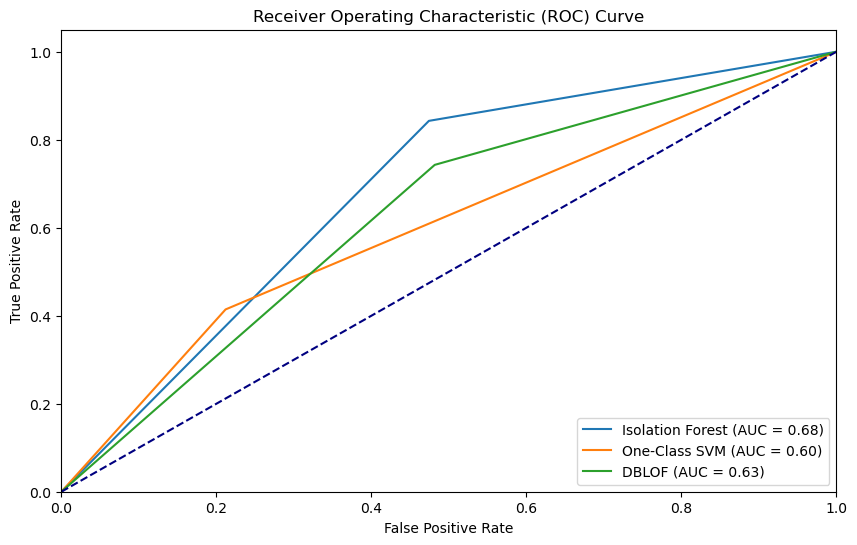

In [27]:
models = ['Isolation Forest', 'One-Class SVM', 'DBLOF']
tpr_list = [if_tpr, ocsvm_tpr, dblof_tpr]
fpr_list = [if_fpr, ocsvm_fpr, dblof_fpr]
auc_list = [if_auc, ocsvm_auc, dblof_auc]


plt.figure(figsize=(10, 6))
for tpr, fpr, auc, model in zip(tpr_list, fpr_list, auc_list, models):
    plt.plot(fpr, tpr, label='%s (AUC = %0.2f)' % (model, auc))

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

plt.savefig('../img/roc_auc.jpg')
plt.show()

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
<br><br>
La curva ROC-AUC muestra que los tres modelos no tienen un rendiminiento que permita una detección eficiente de insiders. Los resultados obtenidos no coinciden con el trabajo de otros autores en el estado del arte.
<br><br>
</div>

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Consideraciones:</strong>
<br><br>
En vista a los resultados obtenidos, se va a optar por escoger modelos de aprendizaje supervisado. De este modo se intentará mejorar los resultados obtenidos.
    
También se valorará un modelo híbrido, que tome las predicciones de los modelos de detección de anomalías y los modelos de clasificación.
<br><br>
</div>